In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [2]:
df = pd.read_csv("Apples_stock price dataset.csv")
df.head()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,01-01-2010 00:00,102.48,7984.16,2994.24,4.59,6.84,1.18,0.10
1,01-01-2010 01:00,99.35,7995.71,2995.83,2.63,5.85,1.92,-0.24
2,01-01-2010 02:00,103.32,8000.89,2998.12,2.62,6.24,2.44,-0.83
3,01-01-2010 03:00,107.73,7995.76,3004.53,3.12,6.40,2.37,0.06
4,01-01-2010 04:00,98.98,8002.45,2997.15,4.27,4.94,1.93,-0.22


In [3]:
df.isnull().sum()

timestamp             0
stock_price          31
nasdaq_index          7
sp500_index           4
inflation_rate        8
unemployment_rate     4
interest_rate         2
market_sentiment      4
dtype: int64

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M')

In [5]:
print(df['timestamp'].tail())

99995   2021-05-29 11:00:00
99996   2021-05-29 12:00:00
99997   2021-05-29 13:00:00
99998   2021-05-29 14:00:00
99999   2021-05-29 15:00:00
Name: timestamp, dtype: datetime64[ns]


In [6]:
df['stock_price'] = df['stock_price'].ffill()

In [7]:
col_fill = [
    'nasdaq_index',
    'sp500_index',
    'inflation_rate',
    'unemployment_rate',
    'interest_rate',
    'market_sentiment']

for col in col_fill:
    df[col] = df[col].fillna(df[col].median())

In [8]:
df.isnull().sum()

timestamp            0
stock_price          0
nasdaq_index         0
sp500_index          0
inflation_rate       0
unemployment_rate    0
interest_rate        0
market_sentiment     0
dtype: int64

In [9]:
df.describe()

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,2015-09-15 07:30:00,299.984698,259114.534761,101463.063479,3.004250,4.99599,2.001476,0.003208
min,2010-01-01 00:00:00,9.540000,7984.160000,2981.780000,1.000000,3.00000,0.500000,-1.000000
25%,2012-11-07 15:45:00,248.605000,134729.690000,51575.350000,2.010000,4.00000,1.250000,-0.500000
50%,2015-09-15 07:30:00,300.070000,257861.010000,100923.145000,3.010000,4.99000,2.000000,0.000000
75%,2018-07-22 23:15:00,351.440000,385204.717500,151634.497500,4.000000,5.99000,2.750000,0.500000
max,2021-05-29 15:00:00,601.660000,507957.790000,200815.810000,5.000000,7.00000,3.500000,1.000000
std,NaN,91.448911,144509.314033,57293.368074,1.152747,1.15467,0.864926,0.578062


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          100000 non-null  datetime64[ns]
 1   stock_price        100000 non-null  float64       
 2   nasdaq_index       100000 non-null  float64       
 3   sp500_index        100000 non-null  float64       
 4   inflation_rate     100000 non-null  float64       
 5   unemployment_rate  100000 non-null  float64       
 6   interest_rate      100000 non-null  float64       
 7   market_sentiment   100000 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.1 MB


In [11]:
df

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 00:00:00,102.48,7984.16,2994.24,4.59,6.84,1.18,0.10
1,2010-01-01 01:00:00,99.35,7995.71,2995.83,2.63,5.85,1.92,-0.24
2,2010-01-01 02:00:00,103.32,8000.89,2998.12,2.62,6.24,2.44,-0.83
3,2010-01-01 03:00:00,107.73,7995.76,3004.53,3.12,6.40,2.37,0.06
4,2010-01-01 04:00:00,98.98,8002.45,2997.15,4.27,4.94,1.93,-0.22
...,...,...,...,...,...,...,...,...
99995,2021-05-29 11:00:00,498.72,507952.14,200804.70,3.82,3.62,3.32,-0.16
99996,2021-05-29 12:00:00,497.04,507943.81,200807.80,1.75,4.90,2.72,0.17
99997,2021-05-29 13:00:00,501.97,507932.52,200809.97,2.42,4.99,1.68,-0.48
99998,2021-05-29 14:00:00,498.91,507942.05,200807.35,2.79,5.86,1.08,0.40


In [12]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])

def replace_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std
    df[column] = np.where(df[column] > upper_bound, mean, df[column])
    df[column] = np.where(df[column] < lower_bound, mean, df[column])
    return df


outlier_col = ['stock_price', 'nasdaq_index', 'sp500_index']

for col in outlier_col:
    df = replace_outliers(df, col)

# Verify the changes
print(df.describe())

                 timestamp    stock_price   nasdaq_index    sp500_index  \
count               100000  100000.000000  100000.000000  100000.000000   
mean   2015-09-15 07:30:00     299.980598  259130.040440  101460.017775   
min    2010-01-01 00:00:00     134.110000   33594.140000   12932.260000   
25%    2012-11-07 15:45:00     248.605000  134729.690000   51575.350000   
50%    2015-09-15 07:30:00     300.070000  257861.010000  100923.145000   
75%    2018-07-22 23:15:00     351.440000  385204.717500  151634.497500   
max    2021-05-29 15:00:00     465.680000  483152.470000  190797.200000   
std                    NaN      87.995423  142458.814345   56475.239748   

       inflation_rate  unemployment_rate  interest_rate  market_sentiment  
count   100000.000000      100000.000000  100000.000000     100000.000000  
mean         3.004091           4.996325       2.001528          0.003180  
min          1.200000           3.200000       0.650000         -0.900000  
25%          2.01000

C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\numpy\lib\function_base

In [13]:
for col in ['stock_price', 'nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']:
    df = replace_outliers(df, col)

In [14]:
df = df[df['timestamp'].dt.hour >= 4]

In [15]:
df = df[df['timestamp'].dt.hour < 20]

In [16]:
df = df[df['timestamp'].dt.dayofweek < 5]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47616 entries, 4 to 99979
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          47616 non-null  datetime64[ns]
 1   stock_price        47616 non-null  float64       
 2   nasdaq_index       47616 non-null  float64       
 3   sp500_index        47616 non-null  float64       
 4   inflation_rate     47616 non-null  float64       
 5   unemployment_rate  47616 non-null  float64       
 6   interest_rate      47616 non-null  float64       
 7   market_sentiment   47616 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 3.3 MB


In [18]:

df = df.reset_index(drop=True)

In [19]:
df

,timestamp,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01 04:00:00,134.11,33594.14,12932.26,4.27,4.94,1.93,-0.22
1,2010-01-01 05:00:00,134.11,33594.14,12932.26,2.32,4.10,1.66,-0.83
2,2010-01-01 06:00:00,134.11,33594.14,12932.26,2.63,5.45,3.00,-0.81
3,2010-01-01 07:00:00,134.11,33594.14,12932.26,4.06,3.38,3.28,0.00
4,2010-01-01 08:00:00,134.11,33594.14,12932.26,2.10,4.82,1.76,-0.63
...,...,...,...,...,...,...,...,...
47611,2021-05-28 15:00:00,465.68,483152.47,190797.20,4.80,4.60,2.59,0.35
47612,2021-05-28 16:00:00,465.68,483152.47,190797.20,3.11,3.83,2.44,-0.63
47613,2021-05-28 17:00:00,465.68,483152.47,190797.20,3.79,6.57,0.66,-0.01
47614,2021-05-28 18:00:00,465.68,483152.47,190797.20,2.39,6.59,2.52,0.21


**Visualisation**

BOX PLOT

<Axes: >

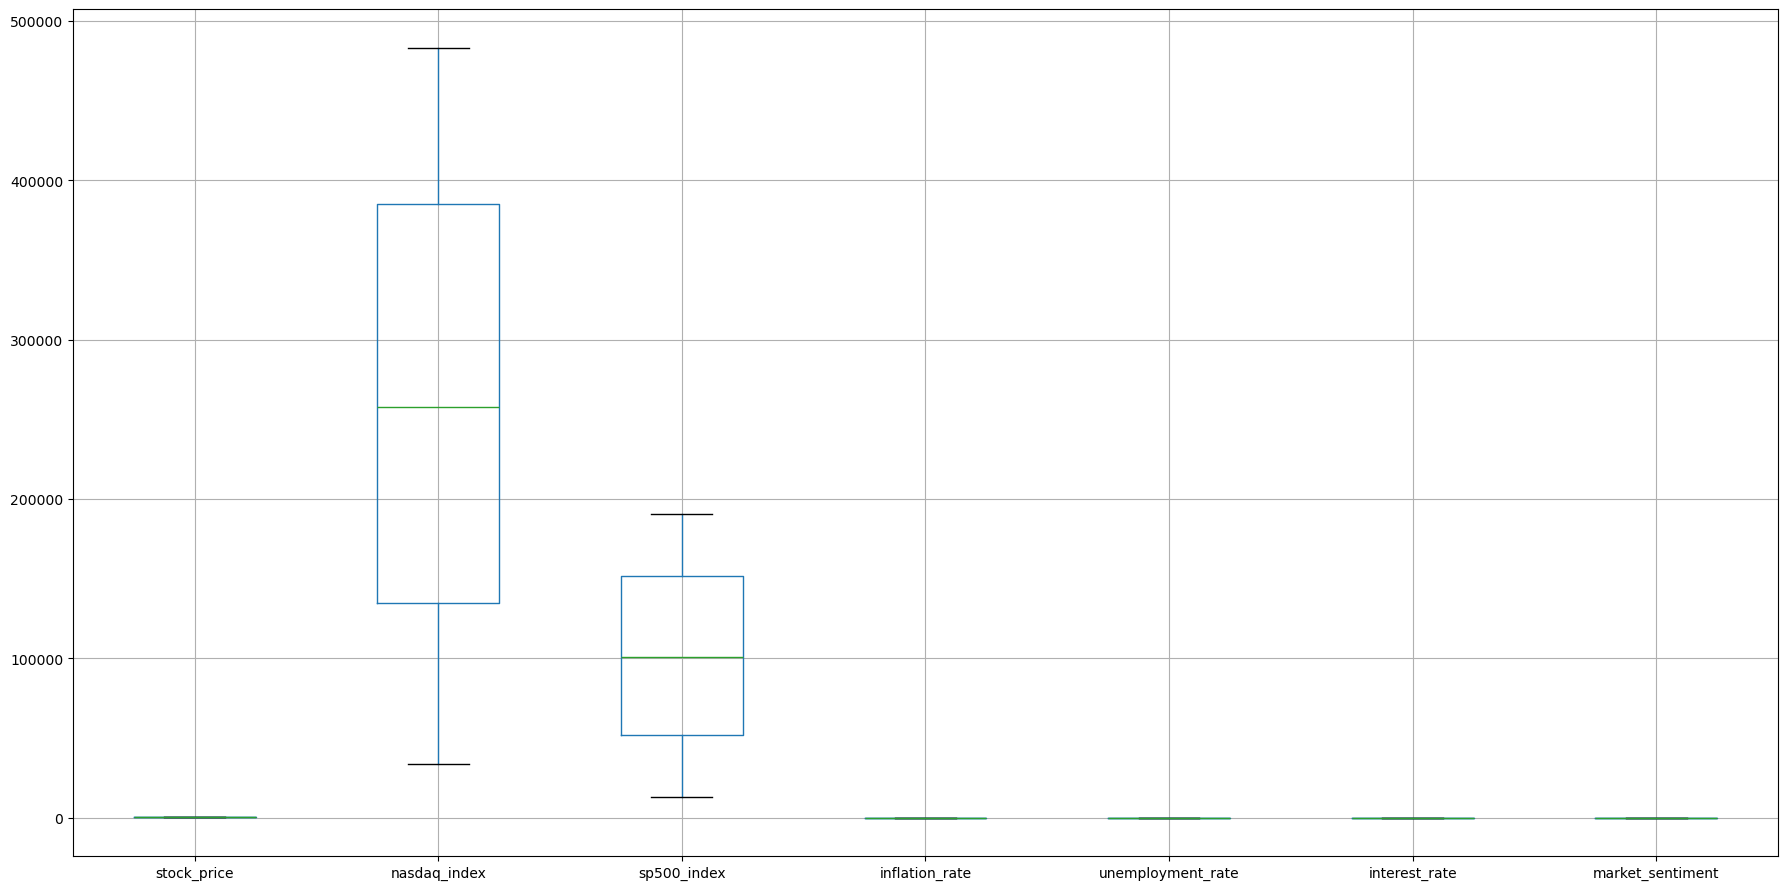

In [20]:
df.boxplot(figsize=(22, 11))

HISTOGRAM



In [21]:
df.hist(figsize=(14, 7))

array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'stock_price'}>,
        <Axes: title={'center': 'nasdaq_index'}>],
       [<Axes: title={'center': 'sp500_index'}>,
        <Axes: title={'center': 'inflation_rate'}>,
        <Axes: title={'center': 'unemployment_rate'}>],
       [<Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'market_sentiment'}>, <Axes: >]],
      dtype=object)

LINE PLOT

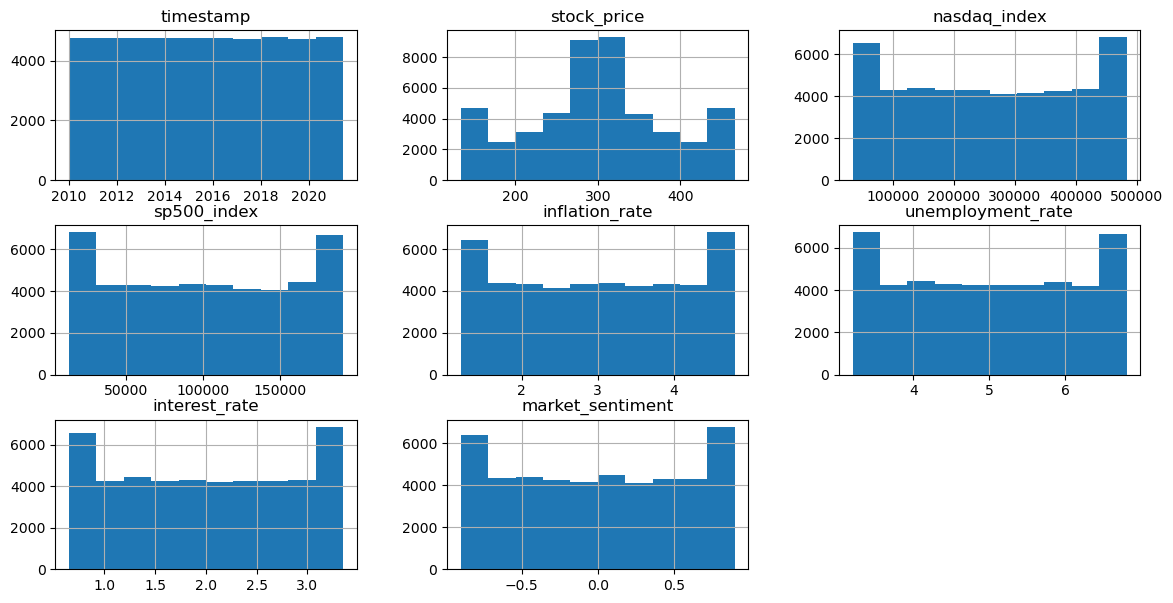

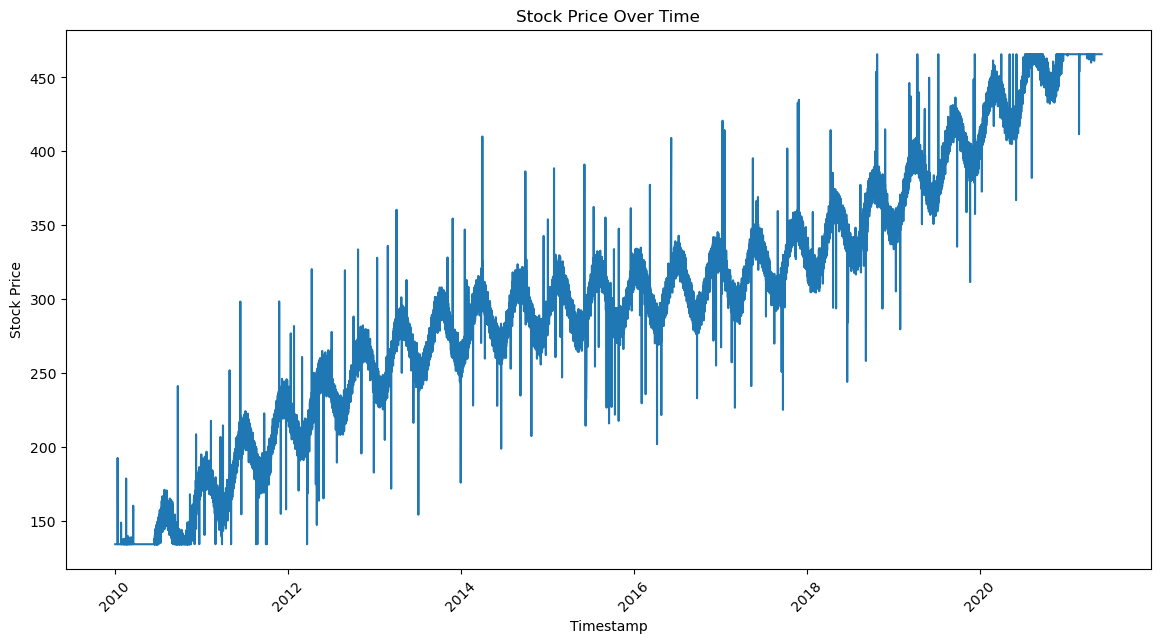

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting stock price over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='stock_price', data=df)
plt.title('Stock Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()


Stock Price vs. NASDAQ Index

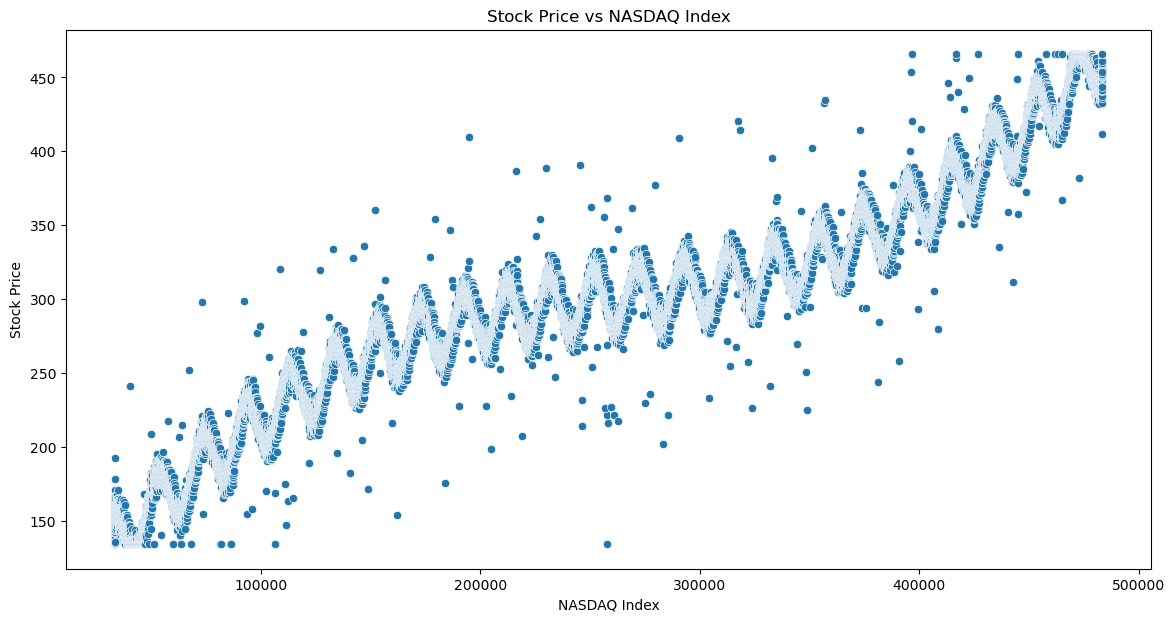

In [23]:
# Scatter plot of stock price vs NASDAQ index
plt.figure(figsize=(14, 7))
sns.scatterplot(x='nasdaq_index', y='stock_price', data=df)
plt.title('Stock Price vs NASDAQ Index')
plt.xlabel('NASDAQ Index')
plt.ylabel('Stock Price')
plt.show()


Stock price VS Sp500 Index

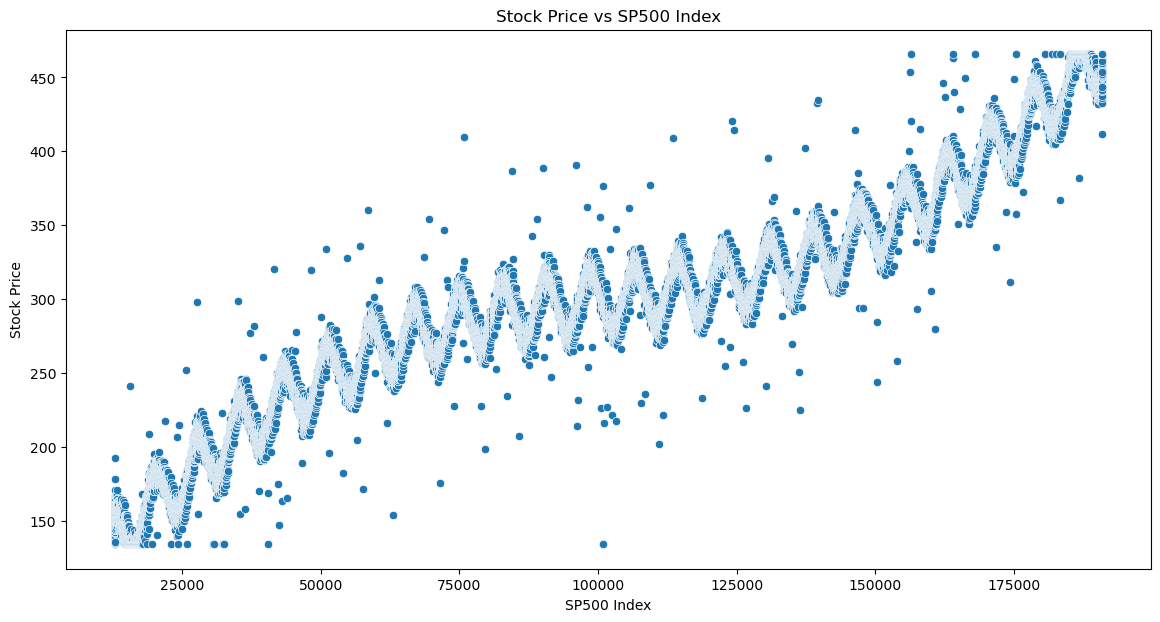

In [24]:
# Scatter plot of stock price vs SP500 index
plt.figure(figsize=(14, 7))
sns.scatterplot(x='sp500_index', y='stock_price', data=df)
plt.title('Stock Price vs SP500 Index')
plt.xlabel('SP500 Index')
plt.ylabel('Stock Price')
plt.show()


3D Scatter Plot

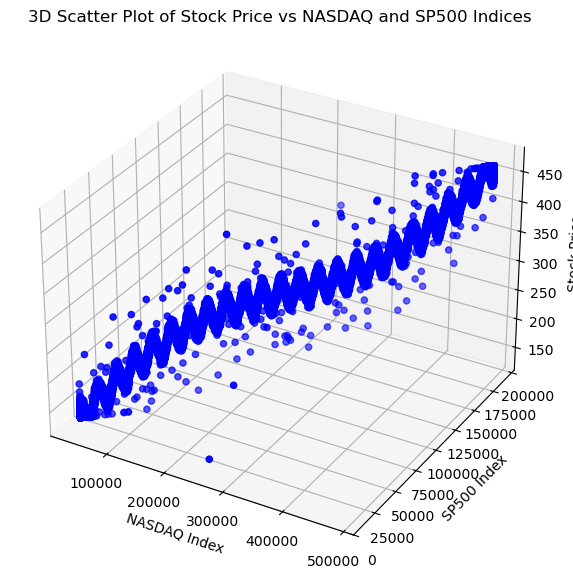

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['nasdaq_index'], df['sp500_index'], df['stock_price'], c='b', marker='o')
ax.set_xlabel('NASDAQ Index')
ax.set_ylabel('SP500 Index')
ax.set_zlabel('Stock Price')
plt.title('3D Scatter Plot of Stock Price vs NASDAQ and SP500 Indices')
plt.show()


Stock Price Distribution

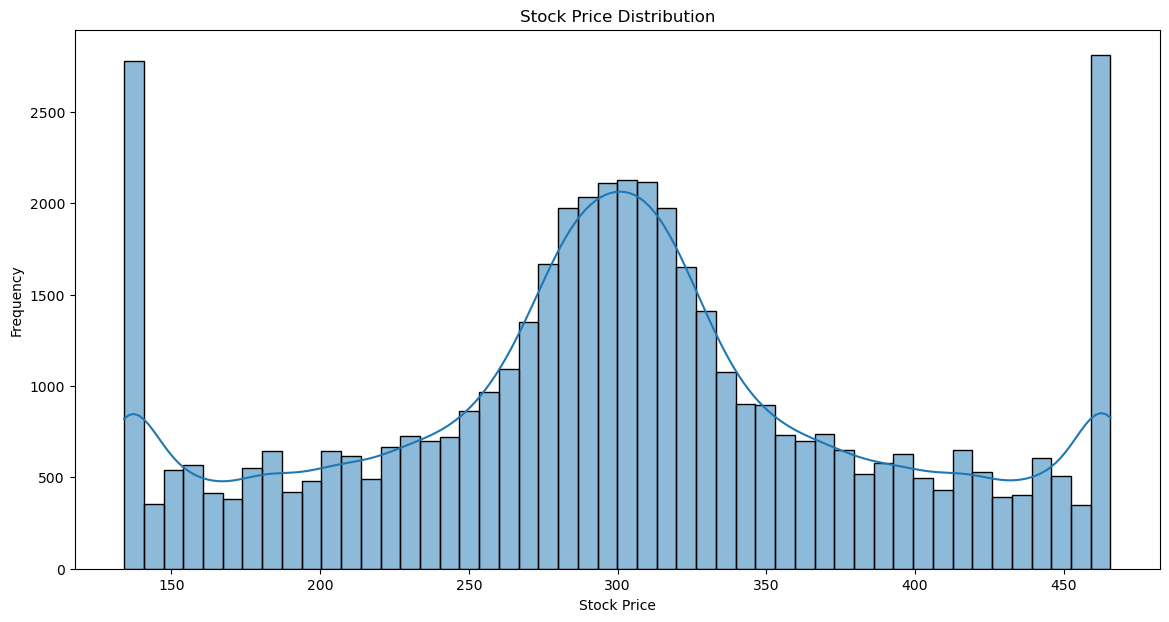

In [26]:
# Histogram of stock price distribution
plt.figure(figsize=(14, 7))
sns.histplot(df['stock_price'], bins=50, kde=True)
plt.title('Stock Price Distribution')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.show()


Correlation Heatmap

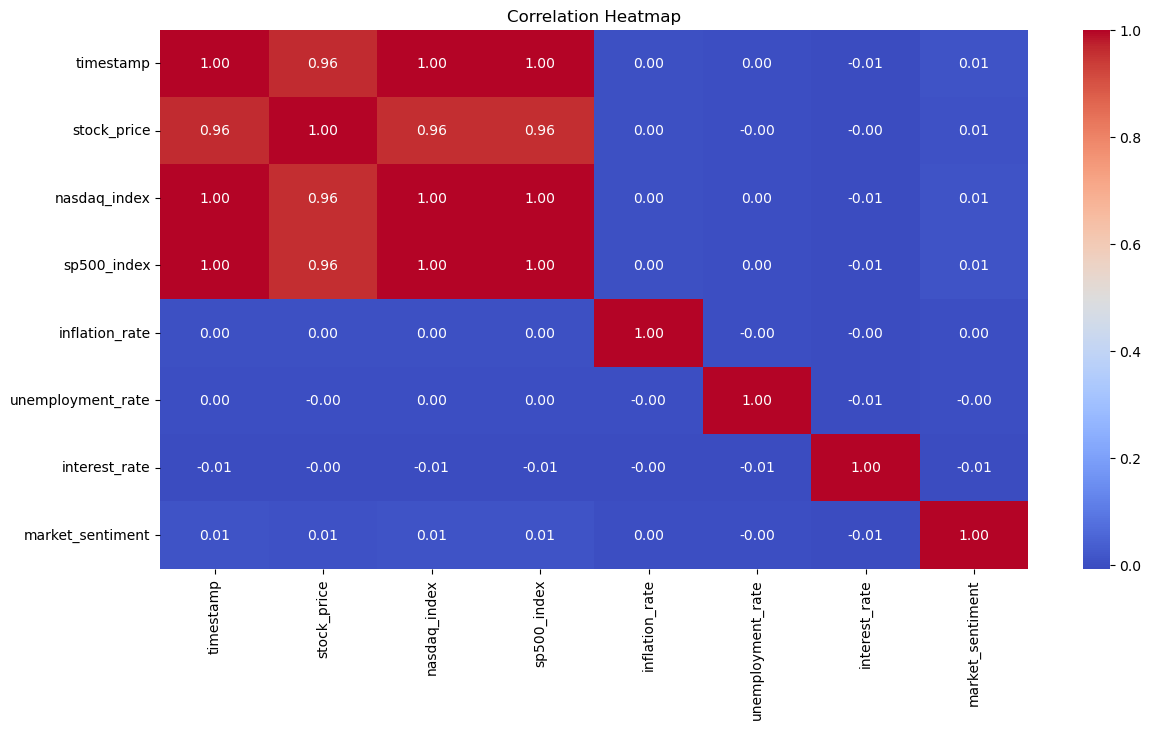

In [27]:
# Correlation heatmap
plt.figure(figsize=(14, 7))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Time Series Decomposition



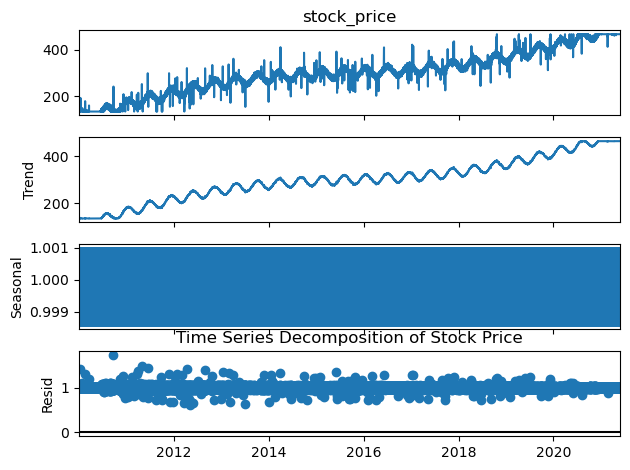

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.set_index('timestamp')['stock_price'], model='multiplicative', period=24)
result.plot()
plt.title('Time Series Decomposition of Stock Price')
plt.show()


## MODELS

In [29]:
X = df[['nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']]
y = df['stock_price']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## MOdel-1 XGBM

In [32]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.25, max_depth=10, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
y_pred_XGBM = xgb_model.predict(X_test_scaled)

In [34]:
mae = mean_absolute_error(y_test,y_pred_XGBM)
mse = mean_squared_error(y_test, y_pred_XGBM)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_XGBM)

In [35]:
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MAE: 5.030618543757054
RMSE: 7.147372995967838
R2 Score: 0.9934688454770397


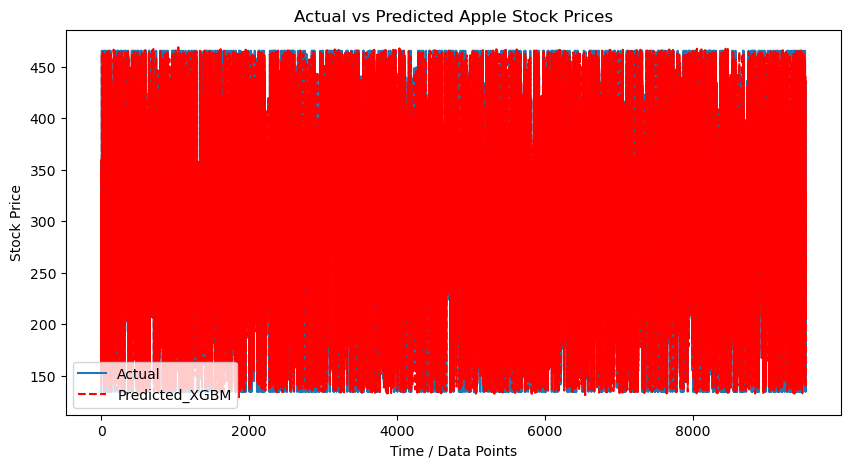

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_XGBM, label='Predicted_XGBM', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Time / Data Points')
plt.ylabel('Stock Price')
plt.show()


## MODEL-2 ARIMA

In [37]:
from statsmodels.tsa.arima.model import ARIMA

In [38]:
arima_model = ARIMA(y_train, order=(5, 1, 0))  # Adjust p, d, q based on data
arima_fit = arima_model.fit()
y_pred_ARIMA = arima_fit.forecast(steps=len(X_test))

C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:8

In [39]:
A_mae = mean_absolute_error(y_test, y_pred_ARIMA)
A_mse = mean_squared_error(y_test, y_pred_ARIMA)
A_rmse = np.sqrt(A_mse)
A_r2 = r2_score(y_test, y_pred_ARIMA)

In [40]:
print(f'MAE: {A_mae}')
print(f'MSE: {A_mse}')
print(f'RMSE: {A_rmse}')
print(f'R2 Score: {A_r2}')

MAE: 70.19575132932177
MSE: 8046.474398357347
RMSE: 89.70214266313457
R2 Score: -0.028733064888840865


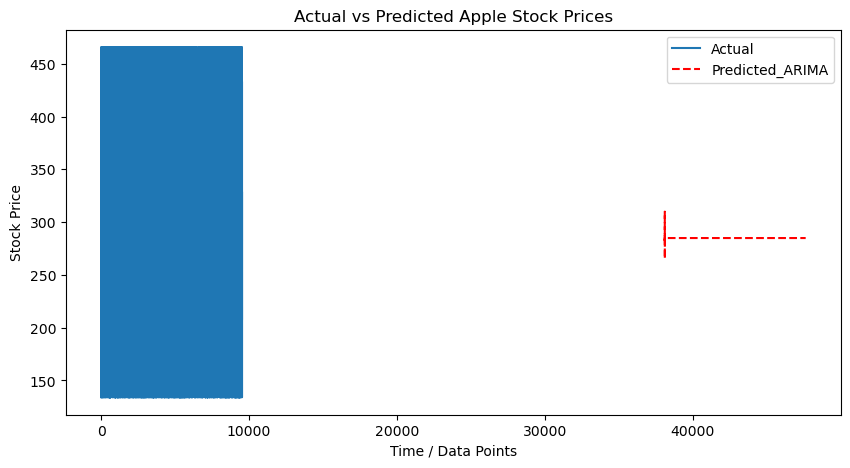

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_ARIMA , label='Predicted_ARIMA', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Time / Data Points')
plt.ylabel('Stock Price')
plt.show()


## MODEL-3 LSTM

In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [43]:
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm)

C:\Users\dvvre\Desktop\T_rex\alpha\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


In [44]:
L_mae = mean_absolute_error(y_test, lstm_pred)
L_mse = mean_squared_error(y_test, lstm_pred)
L_rmse = np.sqrt(L_mse)
L_r2 = r2_score(y_test, lstm_pred)

In [45]:
print(f'MAE: {L_mae}')
print(f'MSE: {L_mse}')
print(f'RMSE: {L_rmse}')
print(f'R2 Score: {L_r2}')

MAE: 12.875979855604305
MSE: 238.59291718138982
RMSE: 15.4464532233581
R2 Score: 0.9694961531223056


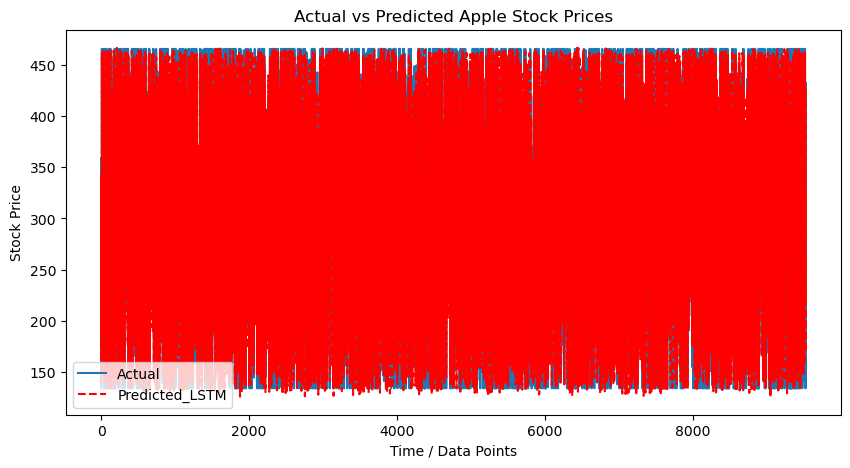

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(lstm_pred, label='Predicted_LSTM', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Time / Data Points')
plt.ylabel('Stock Price')
plt.show()


## MODEL-4 RANDOM FOREST

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [49]:
RF_mae = mean_absolute_error(y_test,rf_pred )
RF_mse = mean_squared_error(y_test,rf_pred )
RF_rmse = np.sqrt(RF_mse)
RF_r2 = r2_score(y_test,rf_pred )

In [50]:
print(f'MAE: {RF_mae}')
print(f'MSE: {RF_mse}')
print(f'RMSE: {RF_rmse}')
print(f'R2 Score: {RF_r2}')

MAE: 4.461039237715242
MSE: 43.86955042789689
RMSE: 6.623409275282397
R2 Score: 0.9943913253391822


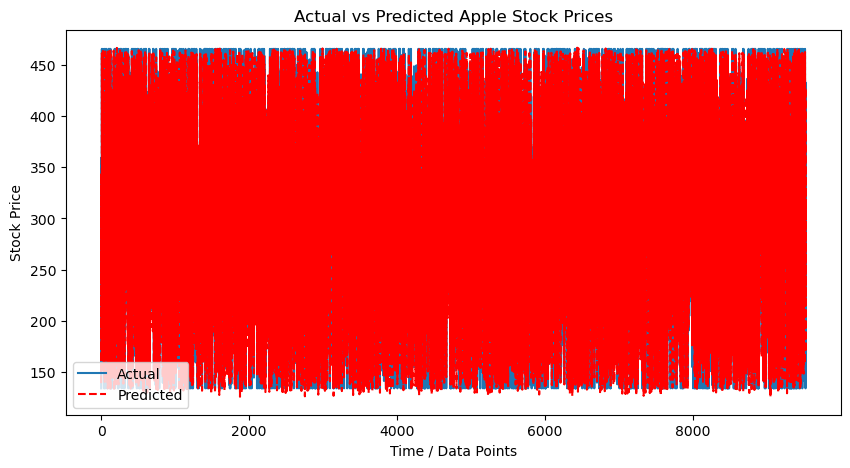

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(lstm_pred, label='Predicted',color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Time / Data Points')
plt.ylabel('Stock Price')
plt.show()


In [52]:
print(f'XGBM_RMSE: {rmse}')
print(f'ARIMA_RMSE: {A_rmse}')
print(f'LSTM_RMSE: {L_rmse}')
print(f'RF_RMSE: {RF_rmse}')


XGBM_RMSE: 7.147372995967838
ARIMA_RMSE: 89.70214266313457
LSTM_RMSE: 15.4464532233581
RF_RMSE: 6.623409275282397


## daily

In [54]:
print(f" data shape: {df.shape}")
print("Last 5 daily timestamps:\n", df['timestamp'].tail())

 data shape: (47616, 8)
Last 5 daily timestamps:
 47611   2021-05-28 15:00:00
47612   2021-05-28 16:00:00
47613   2021-05-28 17:00:00
47614   2021-05-28 18:00:00
47615   2021-05-28 19:00:00
Name: timestamp, dtype: datetime64[ns]


In [55]:
# Step 5: Define prediction horizon (next 30 trading days)
last_timestamp = df['timestamp'].max()
print(f"Last daily timestamp: {last_timestamp}")

Last daily timestamp: 2021-05-28 19:00:00


In [56]:
from pandas.tseries.offsets import BDay

In [57]:
# Generate 30 future trading days (Monday-Friday, skipping weekends)
future_timestamps = pd.date_range(start=last_timestamp + BDay(1), 
                                 periods=30, 
                                 freq=BDay())  # BDay skips weekends
future_df = pd.DataFrame({'timestamp': future_timestamps})
print("First 5 future daily timestamps:\n", future_df.head())

First 5 future daily timestamps:
             timestamp
0 2021-05-31 19:00:00
1 2021-06-01 19:00:00
2 2021-06-02 19:00:00
3 2021-06-03 19:00:00
4 2021-06-04 19:00:00


In [58]:
features = ['nasdaq_index', 'sp500_index', 'inflation_rate', 'unemployment_rate', 'interest_rate', 'market_sentiment']

In [59]:
df['date'] = df['timestamp'].dt.date  # Extract the date part
df_daily = df.groupby('date').mean(numeric_only=True).reset_index()

In [60]:
df_daily

,date,stock_price,nasdaq_index,sp500_index,inflation_rate,unemployment_rate,interest_rate,market_sentiment
0,2010-01-01,134.11,33594.14,12932.26,3.351875,5.173125,2.157500,-0.136875
1,2010-01-04,134.11,33594.14,12932.26,2.953750,5.228125,2.081250,0.280625
2,2010-01-05,134.11,33594.14,12932.26,3.124375,5.046250,2.026250,0.003750
3,2010-01-06,134.11,33594.14,12932.26,3.296875,4.696250,1.853125,0.174375
4,2010-01-07,134.11,33594.14,12932.26,3.409375,5.161875,1.908125,0.248750
...,...,...,...,...,...,...,...,...
2971,2021-05-24,465.68,483152.47,190797.20,3.557500,5.092500,1.953750,-0.133125
2972,2021-05-25,465.68,483152.47,190797.20,3.572500,4.778125,2.146875,0.096250
2973,2021-05-26,465.68,483152.47,190797.20,2.715000,4.170625,2.044375,-0.203125
2974,2021-05-27,465.68,483152.47,190797.20,2.635000,5.379375,1.829375,0.193750


In [61]:
X = df_daily[features].dropna()  # Features for training
y = df_daily['stock_price'].dropna()  # Target variable (stock_price)

# Ensure X and y have the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {rmse}")

Validation RMSE: 2.6180141011076175


In [62]:
last_30_days = df_daily.tail(30)

In [63]:
nasdaq_changes = last_30_days['nasdaq_index'].pct_change().dropna()  # Daily % change
sp500_changes = last_30_days['sp500_index'].pct_change().dropna()    # Daily % change
avg_nasdaq_change = nasdaq_changes.mean()  # Average daily % change
avg_sp500_change = sp500_changes.mean()

In [64]:
print(f"Average daily % change in nasdaq_index: {avg_nasdaq_change * 100:.2f}%")
print(f"Average daily % change in sp500_index: {avg_sp500_change * 100:.2f}%")

Average daily % change in nasdaq_index: 0.00%
Average daily % change in sp500_index: 0.00%


In [65]:
last_row = df_daily.iloc[-1].copy()  # Last daily row
future_X = pd.DataFrame([last_row[features]] * 30, columns=features)

In [66]:
# Apply the average daily change to nasdaq_index and sp500_index
future_X['nasdaq_index'] = last_row['nasdaq_index'] * (1 + avg_nasdaq_change) ** np.arange(1, 31)
future_X['sp500_index'] = last_row['sp500_index'] * (1 + avg_sp500_change) ** np.arange(1, 31)

In [67]:
print("First 5 rows of future features:\n", future_X.head())

First 5 rows of future features:
       nasdaq_index  sp500_index  inflation_rate  unemployment_rate  \
2975     483152.47     190797.2        3.166875            5.11125   
2975     483152.47     190797.2        3.166875            5.11125   
2975     483152.47     190797.2        3.166875            5.11125   
2975     483152.47     190797.2        3.166875            5.11125   
2975     483152.47     190797.2        3.166875            5.11125   

      interest_rate  market_sentiment  
2975       1.961875         -0.089375  
2975       1.961875         -0.089375  
2975       1.961875         -0.089375  
2975       1.961875         -0.089375  
2975       1.961875         -0.089375  


In [68]:
# Step 7: Predict daily prices
rf_future_pred = rf.predict(future_X)
future_df['predicted_stock_price'] = rf_future_pred

In [69]:
# Combine with timestamps
rf_predictions = pd.DataFrame({'timestamp': future_timestamps, 'predicted_stock_price': rf_future_pred})
print("Daily predictions:\n", rf_predictions)

Daily predictions:
              timestamp  predicted_stock_price
0  2021-05-31 19:00:00             465.657406
1  2021-06-01 19:00:00             465.657406
2  2021-06-02 19:00:00             465.657406
3  2021-06-03 19:00:00             465.657406
4  2021-06-04 19:00:00             465.657406
5  2021-06-07 19:00:00             465.657406
6  2021-06-08 19:00:00             465.657406
7  2021-06-09 19:00:00             465.657406
8  2021-06-10 19:00:00             465.657406
9  2021-06-11 19:00:00             465.657406
10 2021-06-14 19:00:00             465.657406
11 2021-06-15 19:00:00             465.657406
12 2021-06-16 19:00:00             465.657406
13 2021-06-17 19:00:00             465.657406
14 2021-06-18 19:00:00             465.657406
15 2021-06-21 19:00:00             465.657406
16 2021-06-22 19:00:00             465.657406
17 2021-06-23 19:00:00             465.657406
18 2021-06-24 19:00:00             465.657406
19 2021-06-25 19:00:00             465.657406
20 2021-06-28 

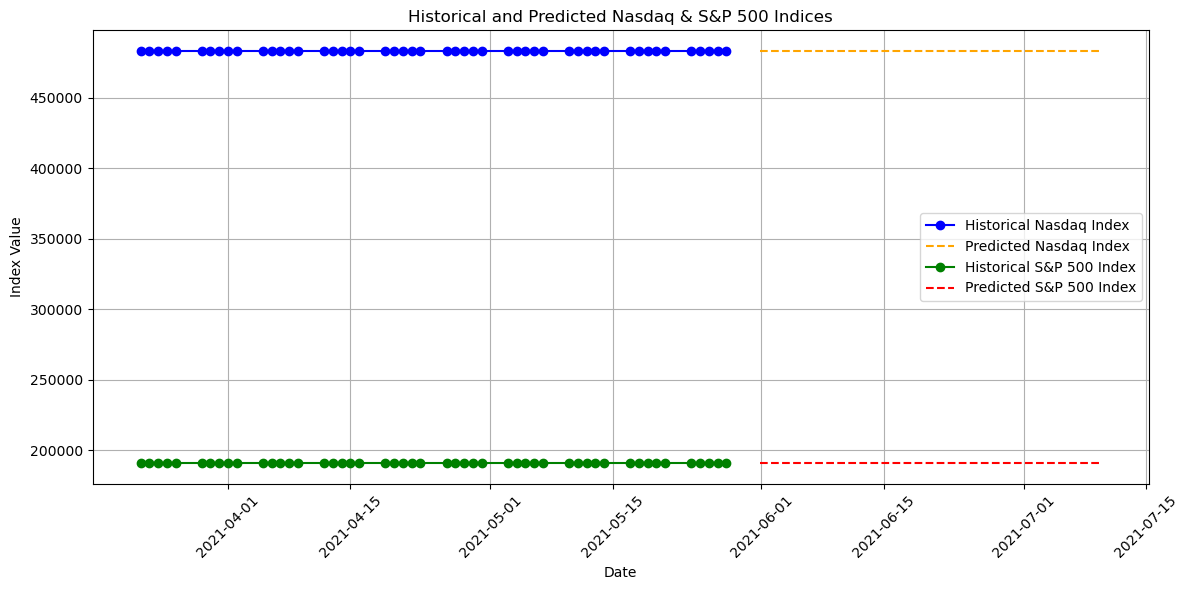

In [70]:
plt.figure(figsize=(12, 6))

# Plot historical nasdaq_index (last 50 days for context)
plt.plot(df_daily['date'].tail(50), df_daily['nasdaq_index'].tail(50), 
         label='Historical Nasdaq Index', color='blue', marker='o')

# Plot future nasdaq_index
future_X['timestamp'] = future_timestamps  # Add timestamps to future_X
plt.plot(future_X['timestamp'], future_X['nasdaq_index'], 
         label='Predicted Nasdaq Index', color='orange', linestyle='--')

# Plot historical sp500_index (last 50 days for context)
plt.plot(df_daily['date'].tail(50), df_daily['sp500_index'].tail(50), 
         label='Historical S&P 500 Index', color='green', marker='o')

# Plot future sp500_index
plt.plot(future_X['timestamp'], future_X['sp500_index'], 
         label='Predicted S&P 500 Index', color='red', linestyle='--')

# Customize the plot
plt.title('Historical and Predicted Nasdaq & S&P 500 Indices')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

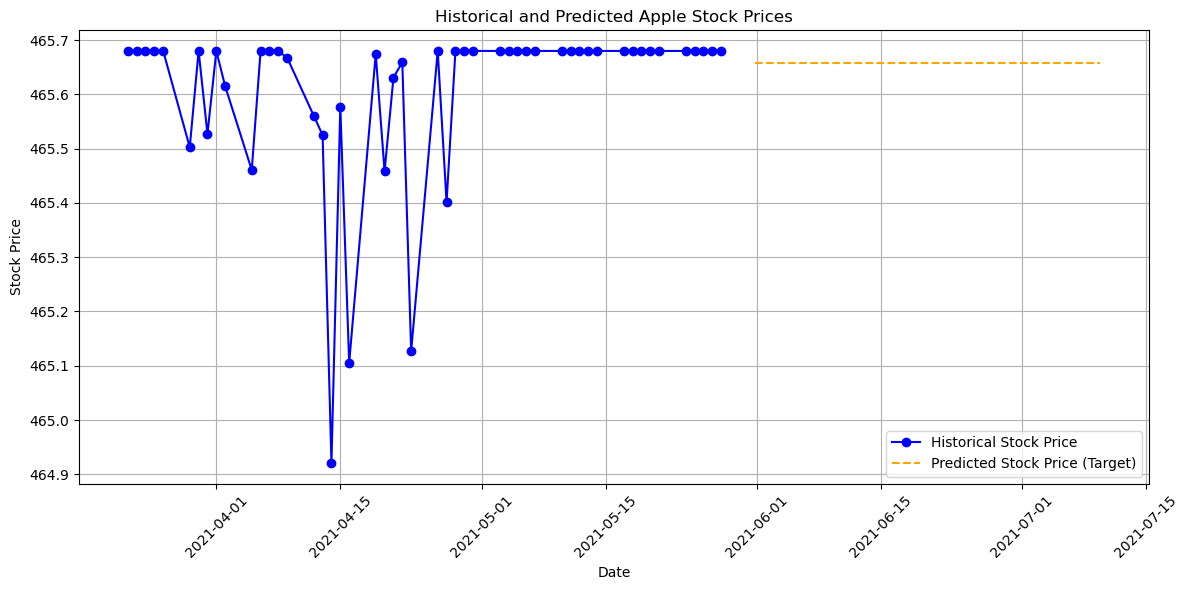

In [71]:
#Visualization
plt.figure(figsize=(12, 6))

# Plot historical stock price (last 50 days for context)
plt.plot(df_daily['date'].tail(50), df_daily['stock_price'].tail(50), 
         label='Historical Stock Price', color='blue', marker='o')

# Plot future stock price predictions
future_df['timestamp'] = pd.to_datetime(future_df['timestamp'])  # Ensure timestamp is datetime
plt.plot(future_df['timestamp'], future_df['predicted_stock_price'], 
         label='Predicted Stock Price (Target)', color='orange', linestyle='--')

# Customize the plot
plt.title('Historical and Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [73]:
# Step 9: Export predictions
rf_predictions.to_csv('apple_stock_next_30_days_daily_RF.csv', index=False)
print("Daily predictions saved to 'Forecasted_30_days_prediction.csv'")

Daily predictions saved to 'Forecasted_30_days_prediction.csv'


## Deployment

In [74]:
import joblib

# Save the trained rf model
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']